In [1]:
data_dir = '/tmp/imagenet'
info_dir = './imagenet_class_hierarchy/modified'
num_workers = 10
batch_size = 10

In [2]:
import os
from robustness.tools.breeds_helpers import setup_breeds

if not (os.path.exists(info_dir) and len(os.listdir(info_dir))):
    print("Downloading class hierarchy information into `info_dir`")
    setup_breeds(info_dir)

In [3]:
from robustness.tools.breeds_helpers import ClassHierarchy
import numpy as np
hier = ClassHierarchy(info_dir)
print(f"# Levels in the hierarchy: {np.max(list(hier.level_to_nodes.keys()))}")
print(f"# Nodes/level:",
  [f"Level {k}: {len(v)}" for k, v in hier.level_to_nodes.items()])

# Levels in the hierarchy: 8
# Nodes/level: ['Level 0: 1', 'Level 1: 2', 'Level 2: 10', 'Level 3: 29', 'Level 4: 128', 'Level 5: 466', 'Level 6: 591', 'Level 7: 98', 'Level 8: 3']


In [4]:
hier.HIER_NODE_NAME["n00001740"]

'entity'

In [56]:
import pandas as pd

hierarchy = hier.level_to_nodes
df = pd.DataFrame(hierarchy.items())
df.head()

,0,1
0,0,[n00001740]
1,1,"[n00004258, n00021939]"
2,2,"[n00015388, n00017222, dummy21, dummy65, n0340..."
3,3,"[n01767661, n01940736, n01909422, n01503061, n..."
4,4,"[n01768244, n01784675, n02159955, n01769347, n..."


In [6]:
hier.traverse(['n00021939'], depth=1)

['n00021939',
 'n03405265',
 'dummy63',
 'n00021265',
 'n03100490',
 'n03051540',
 'dummy44']

In [57]:
d = {'root': ["n00004258", "n00021939"]}
hierarchy_df = pd.DataFrame(data=d)
# hierarchy_df['root_label'] = hierarchy_df.apply(lambda row: hier.HIER_NODE_NAME[row['root']], axis=1)
hierarchy_df

,root
0,n00004258
1,n00021939


In [59]:
def children(row):
    return row if len(row) > 1 else []

def cut(row):
    return row if False else "1"

n_levels = np.max(list(hier.level_to_nodes.keys())) - 1
for level in range(1, n_levels):
    if level == 1:
        hierarchy_df[f'level_{str(level)}'] = hierarchy_df.apply(
            lambda row: hier.traverse([row['root']], depth=1), axis=1
        )
    else:
        hierarchy_df[f'level_{str(level)}'] = hierarchy_df.apply(
            lambda row: hier.traverse(
                [row[f'level_{str(level - 1)}']], depth=1
            ),
            axis=1,
        )
    hierarchy_df = hierarchy_df.explode(f'level_{str(level)}')
        # hierarchy_df[f'level_{str(level)}'] = hierarchy_df.apply(
        #         lambda row: cut(
        #             [row[f'level_{str(level)}']], depth=1
        #         ),
        #         axis=1,
        #     )
    # hierarchy_df['level_' +str(level) +'_label'] = hierarchy_df.apply(lambda row: hier.HIER_NODE_NAME[row['level_' +str(level)]], axis=1)

hierarchy_df

,root,level_1,level_2,level_3,level_4,level_5,level_6
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,n00015388
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,n00017222
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,dummy21
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,dummy65
...,...,...,...,...,...,...,...
1,n00021939,dummy44,n09287968,dummy68,n09246464,n09246464,n09246464
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09406793,n09406793
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09406793,n09256479
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09256479,n09256479


In [63]:
# Check nodes with single children and merge

# level_6_mask = (hierarchy_df[['level_5']].T==hierarchy_df['level_6']).any()
# hierarchy_df['flag']= np.where(level_6_mask)
hierarchy_df['flag'] = (hierarchy_df[['level_5']].T==hierarchy_df['level_6']).any()
hierarchy_df['level_5'] = (hierarchy_df['level_5']).where((hierarchy_df['flag'] == True), hierarchy_df["level_6"])
# hierarchy_df['leaves'] = hierarchy_df.apply(lambda row: len(hier.traverse(row["level_5"], depth=1)), axis=1)
hierarchy_df

,root,level_1,level_2,level_3,level_4,level_5,level_6,flag
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,True
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00015388,n00015388,False
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00017222,n00017222,False
0,n00004258,n00004258,n00004258,n00004258,n00004258,dummy21,dummy21,False
0,n00004258,n00004258,n00004258,n00004258,n00004258,dummy65,dummy65,False
...,...,...,...,...,...,...,...,...
1,n00021939,dummy44,n09287968,dummy68,n09246464,n09246464,n09246464,True
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09406793,n09406793,True
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09256479,n09256479,False
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09256479,n09256479,True


In [64]:
hierarchy_df['flag'] = (hierarchy_df[['level_4']].T==hierarchy_df['level_5']).any()
hierarchy_df['level_4'] = (hierarchy_df['level_4']).where((hierarchy_df['flag'] == True), hierarchy_df["level_5"])
hierarchy_df.drop(["level_6"], axis=1)

,root,level_1,level_2,level_3,level_4,level_5,flag
0,n00004258,n00004258,n00004258,n00004258,n00004258,n00004258,True
0,n00004258,n00004258,n00004258,n00004258,n00015388,n00015388,False
0,n00004258,n00004258,n00004258,n00004258,n00017222,n00017222,False
0,n00004258,n00004258,n00004258,n00004258,dummy21,dummy21,False
0,n00004258,n00004258,n00004258,n00004258,dummy65,dummy65,False
...,...,...,...,...,...,...,...
1,n00021939,dummy44,n09287968,dummy68,n09246464,n09246464,True
1,n00021939,dummy44,n09287968,n09406793,n09406793,n09406793,True
1,n00021939,dummy44,n09287968,n09406793,n09256479,n09256479,False
1,n00021939,dummy44,n09287968,n09406793,n09256479,n09256479,False


In [67]:
# hierarchy_df.drop(["level_5", "level_6"], axis=1, inplace=True)
hierarchy_df.drop(["flag"], axis=1, inplace=True)

In [17]:
# hierarchy_df.to_csv("hierarchy_no_labels.csv", index=False, header=True)

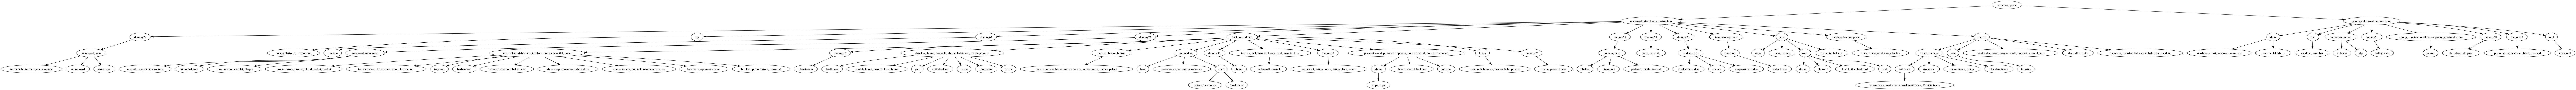

In [11]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image


superclasses = hier.get_nodes_at_level(2)
superclass = list(superclasses)[2]
subtree = nx.ego_graph(hier.graph, superclass, radius=50000)
mapping = {n: hier.HIER_NODE_NAME[n] for n in subtree.nodes()}
subtree = to_agraph(nx.relabel_nodes(subtree, mapping))
subtree.layout('dot')
subtree.draw('graph.png', format='png')
img = Image('graph.png')
img

In [68]:
import json
import pandas as pd

with open('./imagenet_class_hierarchy/modified/dataset_class_info.json', 'r') as file:
    data = json.load(file)

idx_df = pd.DataFrame(data,)
idx_df.columns = ['idx','number','label']
idx_df.dtypes

idx        int64
number    object
label     object
dtype: object

In [70]:
hierarchy_df.dtypes

root       object
level_1    object
level_2    object
level_3    object
level_4    object
dtype: object

In [75]:
merged_df = pd.merge(hierarchy_df, idx_df, how="left", left_on="level_4", right_on='number')
merged_df.drop(['number', 'label'], axis=1, inplace=True)
merged_df.head()

,root,level_1,level_2,level_3,level_4,idx
0,n00004258,n00004258,n00004258,n00004258,n00004258,NaN
1,n00004258,n00004258,n00004258,n00004258,n00015388,NaN
2,n00004258,n00004258,n00004258,n00004258,n00017222,NaN
3,n00004258,n00004258,n00004258,n00004258,dummy21,NaN
4,n00004258,n00004258,n00004258,n00004258,dummy65,NaN


In [76]:
imagenet_1k = merged_df[merged_df['idx'].notnull()]
imagenet_1k = imagenet_1k.drop_duplicates(keep=False)
imagenet_1k['idx'] = imagenet_1k['idx'].astype(int)

In [77]:
imagenet_1k

,root,level_1,level_2,level_3,level_4,idx
34,n00004258,n00004258,n00004258,n00004258,n01768244,69
35,n00004258,n00004258,n00004258,n00004258,n01784675,79
40,n00004258,n00004258,n00004258,n00004258,n01955084,116
178,n00004258,n00004258,n00004258,n00015388,n02190166,308
179,n00004258,n00004258,n00004258,n00015388,n02206856,309
...,...,...,...,...,...,...
13341,n00021939,dummy44,n04341686,n04341686,n04562935,900
13373,n00021939,dummy44,n04341686,n02796623,n04604644,912
13503,n00021939,dummy44,n04341686,n02913152,n04346328,832
13551,n00021939,dummy44,n04341686,n02913152,n02727426,410


In [98]:
idx_df = pd.DataFrame(data,)
idx_df.columns = ['idx','number','label']
idx_df.dtypes

idx        int64
number    object
label     object
dtype: object

In [129]:
d = {'root': ["n00004258", "n00021939"]}
df = pd.DataFrame(data=d)

df = df.explode('root')
df["prompt"] = df.apply(lambda row: "a photo of a " + hier.HIER_NODE_NAME[row['root']].partition(",")[0] + ".", axis=1)
df["classname"] = df.apply(lambda row: hier.HIER_NODE_NAME[row['root']].partition(",")[0], axis=1)
df["classidx"] = "-1"
df.to_csv("prompts_level_1.csv", index=False, header=True)

In [143]:
df_2 = df.copy()
df_2 = df_2.iloc[:, :1]
df_2['level_1'] = df_2.apply(lambda row: hier.traverse([row['root']], depth=1), axis=1)
df_2 = df_2.explode('level_1')
df_2 = df_2[df_2['level_1'] != df_2['root']]

df_2["prompt"] = df_2.apply(lambda row: "a photo of a " + hier.HIER_NODE_NAME[row['level_1']].partition(",")[0] + ".", axis=1)
df_2["classname"] = df_2.apply(lambda row: hier.HIER_NODE_NAME[row['level_1']].partition(",")[0], axis=1)
df_2 = df_2.drop(["root"], axis=1)
# df_2 = pd.merge(df_2, idx_df, how="left", left_on="level_1", right_on='number')
df_2["classidx"] = "-2"
# df.to_csv("prompts_level_1.csv", index=False, header=True)
df_2.to_csv("prompts_level_2.csv", index=False, header=True)

In [144]:
df_3 = df_2.copy()
df_3 = df_3.iloc[: , :1]

df_3['level_2'] = df_2.apply(lambda row: hier.traverse([row['level_1']], depth=1), axis=1)
df_3 = df_3.explode('level_2')
df_3 = df_3[df_3['level_2'] != df_3['level_1']]

df_3["prompt"] = df_3.apply(lambda row: "a photo of a " + hier.HIER_NODE_NAME[row['level_2']].partition(",")[0] + ".", axis=1)
df_3["classname"] = df_3.apply(lambda row: hier.HIER_NODE_NAME[row['level_2']].partition(",")[0], axis=1)
df_3 = df_3.drop(["level_1"], axis=1)
# df_3 = pd.merge(df_3, idx_df, how="left", left_on="level_2", right_on='number')
df_2["classidx"] = "-3"
# df.to_csv("prompts_level_1.csv", index=False, header=True)
df_3.to_csv("prompts_level_3.csv", index=False, header=True)



In [147]:

df_4 = df_3.copy()
df_4 = df_4.iloc[: , :1]

df_4['level_3'] = df_4.apply(lambda row: hier.traverse([row['level_2']], depth=1), axis=1)
df_4 = df_4.explode('level_3')
df_4 = df_4[df_4['level_3'] != df_4['level_2']]

df_4["prompt"] = df_4.apply(lambda row: "a photo of a " + hier.HIER_NODE_NAME[row['level_3']].partition(",")[0] + ".", axis=1)
df_4["classname"] = df_4.apply(lambda row: hier.HIER_NODE_NAME[row['level_3']].partition(",")[0], axis=1)
df_4 = df_4.drop(["level_2"], axis=1)
df_4 = pd.merge(df_4, idx_df, how="left", left_on="level_3", right_on='number')
# breaking it down for image net 1k
df_4 = df_4.drop(["number","label"], axis=1)
df_4 = df_4.rename(columns={"idx":"classidx"})
# df_4 = df_4[df_4['classidx'].notnull()]
# df_2["idx"] = "-3"
# df.to_csv("prompts_level_1.csv", index=False, header=True)
df_4.to_csv("prompts_level_4.csv", index=False, header=True)
df_4

,level_3,prompt,classname,classidx
0,n01768244,a photo of a trilobite.,trilobite,69.0
1,n01784675,a photo of a centipede.,centipede,79.0
2,n02159955,a photo of a insect.,insect,NaN
3,n01769347,a photo of a arachnid.,arachnid,NaN
4,n01974773,a photo of a crustacean.,crustacean,NaN
...,...,...,...,...
123,n09433442,a photo of a shore.,shore,NaN
124,n09214060,a photo of a bar.,bar,NaN
125,n09443453,a photo of a spring.,spring,NaN
126,dummy68,a photo of a dummy68.,dummy68,NaN


In [155]:
df_5 = df_4.copy()
df_5 = df_5.iloc[: , :1]

df_5['level_4'] = df_5.apply(lambda row: hier.traverse([row['level_3']], depth=1), axis=1)
df_5 = df_5.explode('level_4')
df_5 = df_5[df_5['level_4'] != df_5['level_3']]

df_5["prompt"] = df_5.apply(lambda row: "a photo of a " + hier.HIER_NODE_NAME[row['level_4']].partition(",")[0] + ".", axis=1)
df_5["classname"] = df_5.apply(lambda row: hier.HIER_NODE_NAME[row['level_4']].partition(",")[0], axis=1)
df_5 = df_5.drop(["level_3"], axis=1)
df_5 = pd.merge(df_5, idx_df, how="left", left_on="level_4", right_on='number')
# breaking it down for image net 1k
df_5 = df_5.drop(["number","label"], axis=1)
df_5 = df_5.rename(columns={"idx":"classidx"})
# df_5 = df_5[df_5['classidx'].notnull()]
# df_2["idx"] = "-3"
# df.to_csv("prompts_level_1.csv", index=False, header=True)
df_5['classidx'] = df_5['classidx'].fillna(0.0).astype(int)
df_5.to_csv("prompts_level_5.csv", index=False, header=True)
df_5

,level_4,prompt,classname,classidx
0,n02190166,a photo of a fly.,fly,308
1,n02206856,a photo of a bee.,bee,309
2,n02219486,a photo of a ant.,ant,310
3,n02226429,a photo of a grasshopper.,grasshopper,311
4,n02229544,a photo of a cricket.,cricket,312
...,...,...,...,...
461,n09428293,a photo of a seashore.,seashore,978
462,n09421951,a photo of a sandbar.,sandbar,977
463,n09288635,a photo of a geyser.,geyser,974
464,n09246464,a photo of a cliff.,cliff,972
